In [1]:
# This file costructs surrogate models for the input datasets
import numpy as np   
import pandas as pd
import os
import shutil
import json
import math
import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed, dump, load
import sys

# Torch specific module imports
import torch
import gpytorch 

# botorch specific modules
from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.optim import optimize_acqf, optimize_acqf_discrete
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
)
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Tick parameters
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['legend.fontsize'] = 15

# User defined python classes and files
import input_class 
import code_inputs as model_input
import utils_dataset as utilsd
import surrogate_models
import kmeans as km

# Set the random seeds
np.random.seed(0)
torch.manual_seed(0)

# Perform input checks
if model_input.N_SEARCH == 0:
    raise ValueError('Number of searches cannot be 0')

if model_input.NUM_CLUSTER == 1:
    n_batch_per_search = int(model_input.N_BATCH_PER_TRIAL)
else:
    n_batch_per_search = int(model_input.N_BATCH_PER_TRIAL/model_input.N_SEARCH)

Using cpu device


#### K means clustering

In [2]:
Input = input_class.inputs(input_path='../datasets/')
XX_prop, YY, descriptors = Input.read_inputs()
XX_comp_df, YY_df = Input.get_comp()
XX_comp_df

,num carbon,num fluorine,num hydrogen,num nitrogen,num oxygen,num sulfur,num silicon
0,360,0,216,144,72,0,0
1,360,0,216,144,144,0,0
2,432,0,360,144,72,0,0
3,360,0,144,216,216,0,0
4,360,0,144,216,216,0,0
...,...,...,...,...,...,...,...
69835,996,0,576,96,0,0,0
69836,1020,0,576,48,0,0,0
69837,1360,0,768,64,0,0,0
69838,1888,0,1152,128,128,0,0


In [3]:
clustered_dfs = km.k_means(XX_comp_df, YY_df, model_input.NUM_CLUSTER)
sample_dfs = km.draw_samples(clustered_dfs, sample_fraction = 1.00)
samples = km.concat(sample_dfs)
samples

,num carbon,num fluorine,num hydrogen,num nitrogen,num oxygen,num sulfur,num silicon,deliverable capacity [v STP/v]
0,832,0,448,384,0,0,0,165.565439
1,1152,0,832,128,64,0,0,152.524690
2,1376,0,896,256,64,0,0,115.996501
3,864,0,720,192,0,0,0,143.024802
4,1088,0,768,128,0,0,0,153.528996
...,...,...,...,...,...,...,...,...
69835,1536,0,960,160,0,0,0,110.196985
69836,1440,0,1368,216,0,0,36,137.095297
69837,2560,0,1536,384,384,0,0,169.809763
69838,2784,0,1824,576,96,0,0,110.963253


#### Acquisition function 

In [4]:
## TODO: TO BE Check
bounds = torch.tensor([[-10.0], [12.0]])

batch_size = 1
num_restarts= 10 
raw_samples = 512

def optimize_acqf_and_get_observation(acq_func, X_test, Y_test, iteration):
    """Optimizes the acquisition function, and returns a new candidate"""

    candidates, _ = optimize_acqf_discrete(
        acq_function=acq_func,
        choices=X_test,
        q=batch_size,
        max_batch_size=2048,
        num_restarts=num_restarts,
        raw_samples=raw_samples,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        unique=True
    )
    
    print(f'\nBatch {iteration:>2}: Selected Candidate = {candidates}')
    # observe new values
    new_x = candidates.detach()
    b = [1 if torch.all(X_test[i].eq(new_x)) else 0 for i in range(0,X_test.shape[0]) ]
    b = torch.tensor(b).to(torch.int)
    index = b.nonzero()[0][0]
    new_y = torch.reshape(Y_test[0,index],(1,1))
    
    X_test_new = X_test[torch.arange(0, X_test.shape[0]) != index, ...]
    Y_test_new = Y_test[..., torch.arange(0, Y_test.shape[1]) != index]
    
    return new_x, new_y, index, X_test_new, Y_test_new

#### GP Train Function

In [5]:
def create_train_test_data(cluster_dataXX, cluster_dataYY, random_seed):
    if model_input.STANDARDIZE:
        cluster_dataXX, scalerX_transform = utilsd.standardize_data(cluster_dataXX)
        cluster_dataYY, scalerY_transform = utilsd.standardize_data(cluster_dataYY.reshape(-1,1))
    else:
        scalerX_transform = None
        scalerY_transform = None
    
    ## TODO : Incase for feature selection
        # ....
        # ....
        # ....

    # Create train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(cluster_dataXX, cluster_dataYY, test_size=model_input.TEST_SIZE, random_state=random_seed)

    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_train = np.transpose(Y_train) # IMP : Has to have only one row for GP training
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    Y_test = np.transpose(Y_test)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)

    return X_train, X_test, Y_train, Y_test, scalerX_transform, scalerY_transform

def train_gp(X_train, X_test, Y_train, Y_test, model=None):
    best_observed = []
    # Finding best value in initial data
    if model_input.MAXIMIZATION:
        best_observed_value = Y_train.max()
        optimal_solution = torch.cat([Y_train[0],Y_test[0]]).max()
    else:
        best_observed_value = Y_train.min()
        optimal_solution = torch.cat([Y_train[0],Y_test[0]]).min()
    
    # If optimal value is present in the initial dataset sample remove it  
    if (best_observed_value.eq(optimal_solution)) and model_input.MAXIMIZATION:
        print('Max in training set, removing it before training models.')
        optimal_position = torch.argmax(Y_train)
        
        # Add max value to test/exploration set
        X_add_toTest = torch.reshape(X_train[optimal_position,:],(1,X_train.shape[1]))
        X_test = torch.cat([X_test,X_add_toTest])
        Y_add_toTest = torch.reshape(optimal_solution,(1,1))      
        Y_test = torch.cat((Y_test,Y_add_toTest),1)
        
        # Remove max value from training set
        X_train = X_train[torch.arange(0, X_train.shape[0]) != optimal_position, ...]
        Y_train = Y_train[..., torch.arange(0, Y_train.shape[1]) != optimal_position]
        
        # Update best observed value
        best_observed_value = Y_train.max()
        
    elif (best_observed_value.eq(optimal_solution)) and not model_input.MAXIMIZATION:
        print('Min in training set, removing it before training models.')
        optimal_position = torch.argmin(Y_train)
        
        # Add min value to test/exploration set
        X_add_toTest = torch.reshape(X_train[optimal_position,:],(1,X_train.shape[1]))
        X_test = torch.cat([X_test,X_add_toTest])
        Y_add_toTest = torch.reshape(optimal_solution,(1,1))      
        Y_test = torch.cat((Y_test,Y_add_toTest),1)
        
        # Remove min value from training set
        X_train = X_train[torch.arange(0, X_train.shape[0]) != optimal_position, ...]
        Y_train = Y_train[..., torch.arange(0, Y_train.shape[1]) != optimal_position]
        
        # Update best observed value
        best_observed_value = Y_train.min()
    
    # Initialize data for training gp-0 and gp-l models
    X_train0, Y_train0, X_test0, Y_test0 = X_train, Y_train, X_test, Y_test
    
    # Initialize likelihood, GP model and acquisition function for the models
    #--------------------------- GP-0 ---------------------------#
    likelihood_gp0 = gpytorch.likelihoods.GaussianLikelihood()
    if model is None:
        model_gp0 = surrogate_models.ExactGPModel(X_train0, Y_train0, likelihood_gp0) 
    else:
        model_gp0 = model
    AcqFunc_0 = ExpectedImprovement(model=model_gp0, best_f=best_observed_value, maximize=model_input.MAXIMIZATION)
    best_observed.append(best_observed_value.item())  # Appending to best_observed list for the given trial
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, n_batch_per_search + 1):
        # Time start of iteration and end
        t0 = time.monotonic()
  
        if (model_input.N_UPDATE !=0) and ((iteration-1)%model_input.N_UPDATE==0):
            # fit the models every 10 iterations
            model_gp0, likelihood_gp0 = surrogate_models.train_surrogate_gp0(X_train0, Y_train0)
    
        # optimize and get new observation using acquisition function
        new_x0, new_y0, index, X_test_new0, Y_test_new0 = optimize_acqf_and_get_observation(AcqFunc_0, X_test0, Y_test0, iteration)
        
        # Update remaining choices tensor
        X_test0 = X_test_new0
        Y_test0 = Y_test_new0

        # Update training points
        X_train0 = torch.cat([X_train0, new_x0])
        Y_train0 = torch.cat([Y_train0[0], new_y0[0]])
        Y_train0 = torch.reshape(Y_train0,(1,Y_train0.shape[0]))

        # update progress
        if model_input.MAXIMIZATION:
            best_value_ei0 = Y_train0.max()
        elif not model_input.MAXIMIZATION:
            best_value_ei0 = Y_train0.min()
        best_observed.append(best_value_ei0.item())

        # AcqFunc_0 = UpperConfidenceBound(model_gp0, beta=0.1) 
        AcqFunc_0 = ExpectedImprovement(model=model_gp0, best_f=best_value_ei0, maximize=model_input.MAXIMIZATION)

        # Time end of iteration
        t1 = time.monotonic()
    
        if model_input.VERBOSE:
            print(
                f"Batch {iteration:>2}: best_value (GP-0) = ",
                f"{best_value_ei0.item():>4.2f}",
                end="",)
            print(f'\nBatch {iteration:>2}: Iteration time = {t1-t0:>4.2f}.')

    return [best_observed, X_train0, X_test0, Y_train0, Y_test0, model_gp0] 

#### Main Function

In [6]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Create a new directory if it does not exist
isExist = os.path.exists(model_input.OUT_FOLDER)
if not isExist:
    os.makedirs(model_input.OUT_FOLDER)
    print("The new directory is created!", model_input.OUT_FOLDER)

shutil.copy2('surrogate_models.py',model_input.OUT_FOLDER)

# Send the print statements to a log file in the model output folder
print_file_path = model_input.OUT_FOLDER + 'log.txt'
sys.stdout = open(print_file_path, 'w')

# Train each GP model sequentially first then apply the epsilon greed algorithm
for trial in range(1, model_input.N_TRIALS + 1):
    # Make a folder to save all trial data
    os.makedirs(model_input.OUT_FOLDER + f'/trial_{trial}', exist_ok=True)

    t0 = time.monotonic()
    if model_input.RANDOM_SEED == 'time':
        random_seed = int(t0)
    elif model_input.RANDOM_SEED == 'iteration':
        random_seed = trial

    print(f"\n -------------------- Trial {trial:>2} of {model_input.N_TRIALS} --------------------\n", end="")

    # Currently these are saved as np arrays at the end of the trial to the respective model output folder.
    best_observed_all_clusters = []
    X_train_all_clusters = []
    X_test_all_clusters = []
    Y_train_all_clusters = []
    Y_test_all_clusters = []
    model_gps_all_clusters = []

    # Creating the initial training and test sets for each cluster
    for cluster_idx in range(model_input.NUM_CLUSTER):
        XX_desc = list(sample_dfs[cluster_idx].columns[:-1])
        YY_desc = sample_dfs[cluster_idx].columns[-1]
        (
            X_train_idx,
            X_test_idx,
            Y_train_idx,
            Y_test_idx,
            scalerX, 
            scalerY
        ) = create_train_test_data(sample_dfs[cluster_idx][XX_desc].to_numpy(), sample_dfs[cluster_idx][YY_desc].to_numpy(), random_seed)
        dump(scalerX, os.path.join(model_input.OUT_FOLDER + f'/trial_{trial}', f'scalerX_{cluster_idx + 1}.joblib'))
        dump(scalerY, os.path.join(model_input.OUT_FOLDER + f'/trial_{trial}', f'scalerY_{cluster_idx + 1}.joblib'))
        best_observed_all_clusters.append(None)
        X_train_all_clusters.append(X_train_idx)
        X_test_all_clusters.append(X_test_idx)
        Y_train_all_clusters.append(Y_train_idx)
        Y_test_all_clusters.append(Y_test_idx)
        model_gps_all_clusters.append(None)
    
    if model_input.NUM_CLUSTER > 1:
        print(f'\n')
        print(f'Starting the initial search (training all local GPs.)')
        print(f'\n')  

    # Initially training of GPs done in parallel by using joblib
    if model_input.TRAIN_PARALLEL:
        results_cluster_0, results_cluster_1, results_cluster_2 = Parallel(n_jobs=-1)(delayed(train_gp)(X_train_all_clusters[i], X_test_all_clusters[i], Y_train_all_clusters[i], Y_test_all_clusters[i]) for i in range(model_input.NUM_CLUSTER))
        results_all_clusters = [results_cluster_0, results_cluster_1, results_cluster_2]
    else:
        results_all_clusters = []
        for i in range(model_input.NUM_CLUSTER):
            print(f"\n -------------------- Cluster {i + 1:>2} of {model_input.NUM_CLUSTER} --------------------\n", end="")
            results_all_clusters.append(train_gp(X_train_all_clusters[i], X_test_all_clusters[i], Y_train_all_clusters[i], Y_test_all_clusters[i]))

    for i, results_i_cluster in enumerate(results_all_clusters):
        best_observed_all_clusters[i] = results_i_cluster[0] 
        X_train_all_clusters[i] = results_i_cluster[1]
        X_test_all_clusters[i] = results_i_cluster[2]
        Y_train_all_clusters[i] = results_i_cluster[3]
        Y_test_all_clusters[i] = results_i_cluster[4]
        model_gps_all_clusters[i] = results_i_cluster[5] 

    # Do the epsilon greedy search only if number of clusters is greater than 1
    if (model_input.N_SEARCH > 1) and (model_input.NUM_CLUSTER > 1):
        print(f'\n')
        print(f'Starting the epsilon greedy search (choosing which local GP to train next.)')
        print(f'\n')    

        # Now apply the epsilon greedy algorithm and choose which GP to train next
        # Subtracting 1 from the number of searches as the first search is already done
        for i in range(model_input.N_SEARCH - 1):
            random_number = np.random.rand()
            epsilon = model_input.EPSILON
            # Explore using the Epsilon Greedy Exploration Strategy
            if random_number <= epsilon:
                # Selecting a number between 1,2 and 3
                cluster_idx = np.random.choice(range(model_input.NUM_CLUSTER))
                search_text = 'exploring'
            else:
                # Exploit best known action
                cluster_idx = np.argmax([best_observed_all_clusters[k][-1] for k in range(model_input.NUM_CLUSTER)])
                search_text = 'exploiting'
            print(f'\nIteration {i} : Cluster {cluster_idx + 1} is selected for training ({search_text})')
            results = train_gp(X_train_all_clusters[cluster_idx], \
                            X_test_all_clusters[cluster_idx], \
                            Y_train_all_clusters[cluster_idx], \
                            Y_test_all_clusters[cluster_idx], \
                            model=model_gps_all_clusters[cluster_idx])
            
            # Add the best values
            best_observed_all_clusters[cluster_idx].extend(results[0])
            # For the reamaining clusters, extend the last best value
            for j in range(model_input.NUM_CLUSTER):
                if j != cluster_idx:
                    best_observed_all_clusters[j].extend( list( np.ones((len(results[0]),))*best_observed_all_clusters[j][-1] ) )
            X_train_all_clusters[cluster_idx] = results[1]
            X_test_all_clusters[cluster_idx] = results[2]
            Y_train_all_clusters[cluster_idx] = results[3]
            Y_test_all_clusters[cluster_idx] = results[4]
            model_gps_all_clusters[cluster_idx] = results[5]
    
    print(f'<----------- Search completed for trial {trial} ---------->\n')

    # Save the numpy arrays

    if model_input.NUM_CLUSTER > 1:
        filesave_name = 'all_clusters'
    else:
        filesave_name = 'one_cluster'
    dump(best_observed_all_clusters, os.path.join(model_input.OUT_FOLDER + f'/trial_{trial}', f'best_observed_{filesave_name}.joblib'))
    dump(X_train_all_clusters, os.path.join(model_input.OUT_FOLDER + f'/trial_{trial}', f'X_train_{filesave_name}.joblib'))
    dump(X_test_all_clusters, os.path.join(model_input.OUT_FOLDER + f'/trial_{trial}', f'X_test_{filesave_name}.joblib'))
    dump(Y_train_all_clusters, os.path.join(model_input.OUT_FOLDER + f'/trial_{trial}', f'Y_train_{filesave_name}.joblib'))
    dump(Y_test_all_clusters, os.path.join(model_input.OUT_FOLDER + f'/trial_{trial}', f'Y_test_{filesave_name}.joblib'))
    dump(model_gps_all_clusters, os.path.join(model_input.OUT_FOLDER + f'/trial_{trial}', f'model_gp_{filesave_name}.joblib'))


The new directory is created! /Users/nikhilthota/Desktop/lab/projects/SPIRAL/codes_and_datasets/T-NIKHIL/project-localGPs_for_COF/bo_output/results_with_three_clusters/


KeyboardInterrupt: 

In [16]:
best_observed_all_clusters_all_trials = []
for trial in range(1,5):
    # Load files from the trial
    path = f'../bo_output/results_with_three_clusters/trial_{trial}'
    # Load the joblib files
    best_observed_all_clusters_all_trials.append(load(os.path.join(path, 'best_observed_all_clusters.joblib')))

# Convert to a 3D numpy array
best_observed_all_clusters_all_trials = np.array(best_observed_all_clusters_all_trials)
best_observed_all_clusters_all_trials.shape

(4, 3, 306)

Text(0.5, 0, 'Number of Iteration')

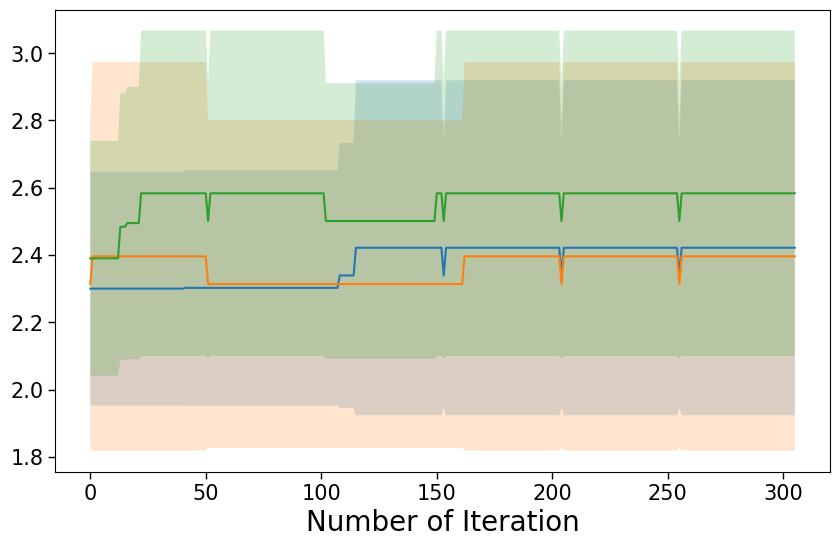

In [22]:
mean_best_observed = []
std_best_observed = []

for i in range(3):
    mean_best_observed.append(np.mean(best_observed_all_clusters_all_trials[:][i][:], axis=0))
    std_best_observed.append(np.std(best_observed_all_clusters_all_trials[:][i][:], axis=0))

# Plot the mean and standard deviation of the best observed values
plt.figure(figsize=(10,6))
for i in range(3):
    plt.plot(mean_best_observed[i], label=f'Cluster {i+1}')
    plt.fill_between(range(len(mean_best_observed[i])), mean_best_observed[i] - std_best_observed[i], mean_best_observed[i] + std_best_observed[i], alpha=0.2)
plt.xlabel('Number of Iteration')  